<a href="https://colab.research.google.com/github/pireylow/stock-price-prediction-LSTM-ARIMA/blob/main/LSTM_Optimise_4_Features_HLOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [2]:
import random
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import yfinance as yf
yf.pdr_override()

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [3]:
#set stock information
ticker = 'SPY'
startdate = '2018-01-01'
enddate = '2023-01-01'

start = pd.to_datetime(startdate)
end = pd.to_datetime(enddate)
sdata = pdr.get_data_yahoo(ticker, start=start, end=end)

columnsTitles=['Open','High','Low','Close','Volume','Adj Close']
sdata=sdata.reindex(columns=columnsTitles)
#sdata.describe()
#sdata.head()

#HLOC ordering .....
    #out_feature_index=0 ==> predict H
    #out_feature_index=1 ==> predict L
    #out_feature_index=2 ==> predict O
    #out_feature_index=3 ==> predict C

nfeatures = 4
feature_set=sdata.to_numpy()[:,[0,1,2,3]]

out_feature_index = 3  #choose to predict the which one
feature_set.shape


[*********************100%***********************]  1 of 1 completed


(1259, 4)

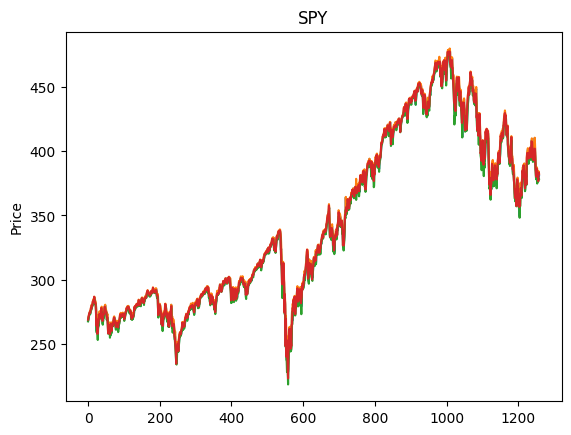

In [4]:
#simple plot for double check of data
plt.title(ticker)
plt.plot(feature_set)
plt.ylabel('Price')
plt.show()

In [5]:
ntrvals = 1200
train_data=feature_set[0:ntrvals,:]
valid_data=feature_set[ntrvals:,:]


In [6]:
#scale the data set
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(feature_set)

yscaler=MinMaxScaler(feature_range=(0,1))
yscaled_data=yscaler.fit_transform(feature_set[:,out_feature_index].reshape(-1,1))

In [7]:
#blocksize (LSTM timesteps) and n_units (LSTM units)
#blocksize_list = list(range(60,80,5))
#n_units_list = list(range(30,50,10))
#blocksize_list = list(range(30,100,10))
#n_units_list = list(range(30,120,10))
blocksize_list = list(range(30,130,10))
n_units_list = list(range(30,160,10))

#set up surf matrices
blocksize_list_length=len(blocksize_list)
n_units_list_length=len(n_units_list)
X = np.zeros((blocksize_list_length,n_units_list_length))
Y = np.zeros((blocksize_list_length,n_units_list_length))
Z = np.zeros((blocksize_list_length,n_units_list_length))

#number of features for LSTM
nfeatures = 4

#loop to train and test ....
blocksize_index=0
for blocksize in blocksize_list:

  n_units_index=0
  for n_units in n_units_list:

    #build the LSTM training set
    x_train_data,y_train_data=[],[]

    #set up
    for i in range(blocksize,len(train_data)-nfeatures+1):
      x_train_data.append(scaled_data[i-blocksize:i,:])
      y_train_data.append(yscaled_data[i])

    x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

    #build the model
    lstm_model=Sequential()
    #lstm_model.add(LSTM(units=n_units,return_sequences=True,input_shape=(x_train_data.shape[1],nfeatures)))
    #lstm_model.add(LSTM(units=n_units,return_sequences=True,input_shape=(x_train_data.shape[1],nfeatures)))
    #lstm_model.add(LSTM(units=n_units))

    lstm_model.add(LSTM(units=n_units,input_shape=(x_train_data.shape[1],nfeatures)))
    lstm_model.add(Dense(15))
    lstm_model.add(Dense(1))

    lstm_model.compile(loss='mean_squared_error',optimizer='adam')
    lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

    #test the model
    inputs_data=scaled_data[feature_set.shape[0]-valid_data.shape[0]-blocksize :,:]
    outputs_data=yscaled_data[feature_set.shape[0]-valid_data.shape[0]-blocksize :,:]

    X_test=[]
    Y_test=[]
    for i in range(blocksize,inputs_data.shape[0]):
      X_test.append(inputs_data[i-blocksize:i,:])
      Y_test.append(outputs_data[i,0])
    X_test=np.array(X_test)
    Y_test=np.array(Y_test)
    Y_test=np.reshape(Y_test,(Y_test.shape[0],1))
    predicted_price=lstm_model.predict(X_test)
    predicted_price=yscaler.inverse_transform(predicted_price)

    mse =  (1/len(valid_data[:,0])) * np.sum((predicted_price[:,0]-valid_data[:,0])*(predicted_price[:,0]-valid_data[:,0]))

    #update surf matrices
    X[blocksize_index,n_units_index] = blocksize
    Y[blocksize_index,n_units_index] = n_units
    Z[blocksize_index,n_units_index] = mse

    print(blocksize_index, n_units_index, blocksize, n_units)
    n_units_index+=1
  blocksize_index+=1




1167/1167 - 8s - loss: 0.0039 - 8s/epoch - 7ms/step
2/2 [==============================] - 1s 10ms/step
0 0 30 30
1167/1167 - 11s - loss: 0.0021 - 11s/epoch - 9ms/step
2/2 [==============================] - 1s 6ms/step
0 1 30 40
1167/1167 - 7s - loss: 0.0020 - 7s/epoch - 6ms/step
2/2 [==============================] - 0s 6ms/step
0 2 30 50
1167/1167 - 6s - loss: 0.0022 - 6s/epoch - 5ms/step
2/2 [==============================] - 0s 6ms/step
0 3 30 60
1167/1167 - 7s - loss: 0.0015 - 7s/epoch - 6ms/step


2/2 [==============================] - 0s 8ms/step
0 4 30 70
1167/1167 - 7s - loss: 0.0020 - 7s/epoch - 6ms/step


2/2 [==============================] - 0s 12ms/step
0 5 30 80
1167/1167 - 7s - loss: 0.0017 - 7s/epoch - 6ms/step
2/2 [==============================] - 0s 7ms/step
0 6 30 90
1167/1167 - 7s - loss: 0.0015 - 7s/epoch - 6ms/step
2/2 [==============================] - 0s 8ms/step
0 7 30 100
1167/1167 - 9s - loss: 0.0019 - 9s/epoch - 8ms/step
2/2 [==============================] - 0s 9ms/step
0 8 30 110
1167/1167 - 8s - loss: 0.0017 - 8s/epoch - 7ms/step
2/2 [==============================] - 0s 11ms/step
0 9 30 120
1167/1167 - 9s - loss: 0.0018 - 9s/epoch - 8ms/step
2/2 [==============================] - 0s 9ms/step
0 10 30 130
1167/1167 - 9s - loss: 0.0017 - 9s/epoch - 7ms/step
2/2 [==============================] - 0s 17ms/step
0 11 30 140
1167/1167 - 10s - loss: 0.0018 - 10s/epoch - 8ms/step
2/2 [==============================] - 0s 13ms/step
0 12 30 150
1157/1157 - 7s - loss: 0.0037 - 7s/epoch - 6ms/step
2/2 [==============================] - 0s 6ms/step
1 0 40 30
1157/1157 - 7s - los

In [8]:
x_train_data.shape

(1077, 120, 4)

In [9]:
X_test.shape

(59, 120, 4)


LSTM timesteps with Min MSE =  110
LSTM units with Min MSE =  130
Min MSE =  32.0422866341137


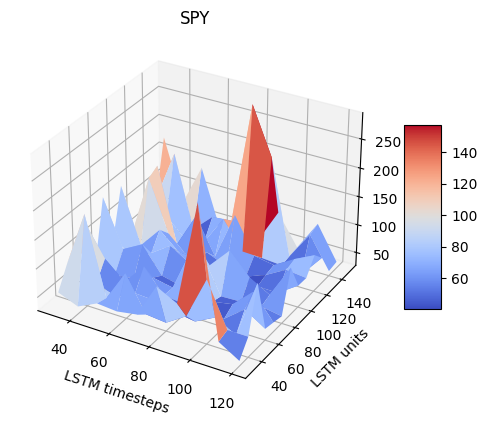

In [10]:
#get min MSE and surf plaot
print()
minptr = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
print('LSTM timesteps with Min MSE = ', int(X[minptr]))
print('LSTM units with Min MSE = ', int(Y[minptr]))
print('Min MSE = ', Z[minptr])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(ticker)
ax.set_xlabel('LSTM timesteps')
ax.set_ylabel('LSTM units')
ax.set_zlabel('Prediction MSE')
plt.show()


In [11]:
Z

array([[ 53.98005142,  89.78805783, 115.53940911, 137.26417269,
         50.24654808, 154.63974503,  66.94690532, 149.39759342,
         43.06643917,  36.3088887 ,  53.28570736,  75.8906673 ,
        174.54082225],
       [ 39.91671827, 187.31162599,  53.06555947,  82.85796835,
         39.80920679,  72.68373853,  47.60777794,  52.93539182,
        159.85468093, 169.83693674,  65.92046492, 166.8322223 ,
         65.74760079],
       [ 56.42066671,  51.76561846,  39.48080219,  51.93233697,
         44.29436364,  91.49201601,  62.36254147,  90.96493742,
         71.19151295,  37.85363469,  34.03330195,  39.19840428,
        138.5823016 ],
       [ 53.47792851, 106.03933851,  56.86873521,  90.54671631,
         56.32942748,  46.12038342,  86.04376446,  60.16670048,
         39.59049397,  99.28124995,  39.26381176,  71.65984082,
         34.20131753],
       [ 59.27689111,  44.98660095,  54.69522405,  49.78565967,
         49.37206418,  37.68539784,  64.25750604,  60.4303177 ,
         57.